# 垃圾回收机制

## 对象的计数引用

In [2]:
import os
import psutil

# 显示当前 python 程序占用的内存大小
def show_memory_info(hint):
    pid = os.getpid()
    p = psutil.Process(pid)
    
    info = p.memory_full_info()
    memory = info.uss / 1024. / 1024
    print('{} memory used: {} MB'.format(hint, memory))

显示内存占用的示例：

In [ ]:
def func():
    show_memory_info('initial')
    a = [i for i in range(10000000)]
    show_memory_info('after a created')

func()
show_memory_info('finished')


In [10]:
# 调整一下
def func():
    show_memory_info('initial')
    global a
    a = [i for i in range(10000000)]
    show_memory_info('after a created')

func()
show_memory_info('finished')

initial memory used: 864.234375 MB
after a created memory used: 1068.30078125 MB
finished memory used: 1068.30078125 MB


上面 global a 表示将 a 声明为全局变量。那么，即使函数返回后，列表的引用依然存在，于是对象就不会被垃圾回收掉，依然占用大量内存。

In [11]:
def func():
    show_memory_info('initial')
    a = [i for i in derange(10000000)]
    show_memory_info('after a created')
    return a

a = func()
show_memory_info('finished')

initial memory used: 1068.3046875 MB


NameError: name 'derange' is not defined

In [12]:
import sys

a = []

# 两次引用，一次来自 a，一次来自 getrefcount
print(sys.getrefcount(a))

def func(a):
    # 四次引用，a，python 的函数调用栈，函数参数 和 getrefcount
    print(sys.getrefcount(a))

func(a)

# 两次引用，一次来自 a，一次来自 getrefcount，函数 func 调用已经不存在
print(sys.getrefcount(a))


2
4
2


sys.getrefcount() 这个函数，可以查看一个变量的引用次数。这段代码本身应该很好理解，不过别忘了，getrefcount 本身也会引入一次计数。

在函数调用发生的时候，会产生额外的两次引用，一次来自函数栈，另一个是函数参数。


In [14]:
import sys

a = []
print(sys.getrefcount(a)) # 两次

b = a
print(sys.getrefcount(a)) # 三次

c = b
d = b
e = c
f = e
g = d
print(sys.getrefcount(a)) # 八次

2
3
8


看到这段代码，需要你稍微注意一下，a、b、c、d、e、f、g 这些变量全部指代的是同一个对象，而 sys.getrefcount() 函数并不是统计一个指针，而是要统计一个对象被引用的次数，所以最后一共会有八次引用。

Python 是自动垃圾回收机制，如果要手动触发垃圾回收，方法同样很简单。你只需要先调用 del a 来删除对象的引用；然后强制调用 gc.collect()，清除没有引用的对象，即可手动启动垃圾回收。



In [15]:
import gc

show_memory_info('initial')

a = [i for i in range(10000000)]

show_memory_info('after a created')

del a
gc.collect()

show_memory_info('finish')
print(a)


initial memory used: 1055.5625 MB
after a created memory used: 1168.23046875 MB
finish memory used: 881.03515625 MB


NameError: name 'a' is not defined

引用次数为 0 是垃圾回收启动的充要条件吗？还有没有其他可能性呢？

充分非必要条件。

## 循环引用

如果有两个对象，它们互相引用，并且不再被别的对象所引用，那么它们应该被垃圾回收吗？


In [18]:
def func():
    show_memory_info('initial')
    a = [i for i in range(10000000)]
    b = [i for i in range(10000000)]
    show_memory_info('after a, b created')
    a.append(b)
    b.append(a)

func()
# gc.collect()
show_memory_info('finished')

initial memory used: 827.83984375 MB
after a, b created memory used: 959.234375 MB
finished memory used: 959.234375 MB


这里，a 和 b 互相引用，并且，作为局部变量，在函数 func 调用结束后，a 和 b 这两个指针从程序意义上已经不存在了。但是，很明显，依然有内存占用！为什么呢？因为互相引用，导致它们的引用数都不为 0。

如果这段代码出现在生产环境中，哪怕 a 和 b 一开始占用的空间不是很大，但经过长时间运行后，Python 所占用的内存一定会变得越来越大，最终 OOM 。

Python 本身是可以处理这个问题的，把上面的 `gc.collect()` 注释去掉看看。

Python 使用标记清除（mark-sweep）算法和分代收集（generational），来启用针对循环引用的自动垃圾回收。

- 标记清除算法
   
   我们先用图论来理解不可达的概念。对于一个有向图，如果从一个节点出发进行遍历，并标记其经过的所有节点；那么，在遍历结束后，所有没有被标记的节点，我们就称之为不可达节点。这些节点的存在已经没有任何意义了，我们就需要对它们进行垃圾回收。
   
   每次都遍历全图，对于 Python 而言是一种巨大的性能浪费。所以，在 Python 的垃圾回收实现中，mark-sweep 使用双向链表维护了一个数据结构，并且只考虑容器类的对象（只有容器类对象才有可能产生循环引用）。

- 分代收集算法，则是另一个优化手段。

   Python 将所有对象分为三代。刚刚创立的对象是第 0 代；经过一次垃圾回收后，依然存在的对象，便会依次从上一代挪到下一代。而每一代启动自动垃圾回收的阈值，则是可以单独指定的。当垃圾回收器中新增对象减去删除对象达到相应的阈值时，就会对这一代对象启动垃圾回收。

   分代收集基于的思想是，新生的对象更有可能被垃圾回收，而存活更久的对象也有更高的概率继续存活。因此，通过这种做法，可以节约不少计算量，从而提高 Python 的性能。


## 调试内存泄漏

objgraph
  
可视化引用关系的包。在这个包中，我主要推荐两个函数，
  
- show_refs()，它可以生成清晰的引用关系图。通过下面这段代码和生成的引用调用图，你能非常直观地发现，有两个 list 互相引用，说明这里极有可能引起内存泄露。这样一来，再去代码层排查就容易多了。


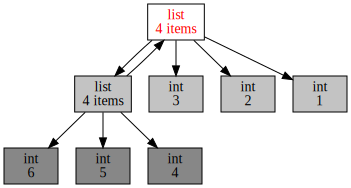

In [20]:
import objgraph

a = [1, 2, 3]
b = [4, 5, 6]

a.append(b)
b.append(a)

objgraph.show_refs([a])

- show_backrefs()

   这个 API 有很多有用的参数，比如层数限制（max_depth）、宽度限制（too_many）、输出格式控制（filename output）、节点过滤（filter, extra_ignore）等。[文档](https://mg.pov.lt/objgraph/)

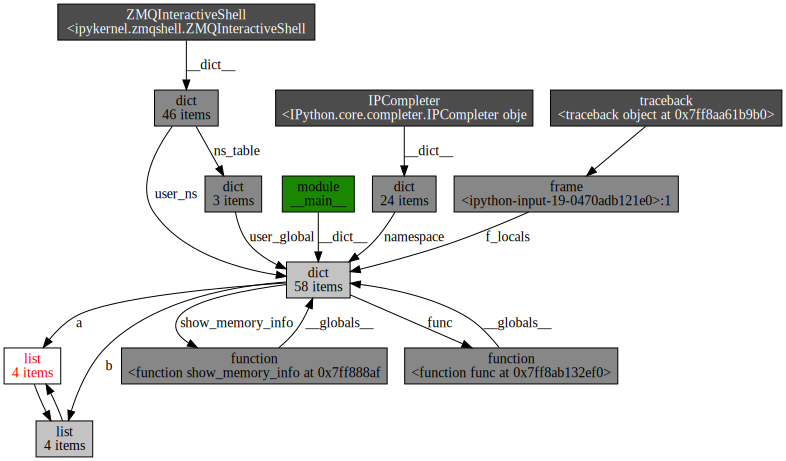

In [21]:
import objgraph

a = [1, 2, 3]
b = [4, 5, 6]

a.append(b)
b.append(a)

objgraph.show_backrefs([a])

## 总结

- 垃圾回收是 Python 自带的机制，用于自动释放不会再用到的内存空间；
- 引用计数是其中最简单的实现，不过切记，这只是充分非必要条件，因为循环引用需要通过不可达判定，来确定是否可以回收；
- Python 的自动回收算法包括标记清除和分代收集，主要针对的是循环引用的垃圾收集；
- 调试内存泄漏方面， objgraph 是很好的可视化分析工具。

## 思考题

实现一个垃圾回收判定算法呢？要求很简单，输入是一个有向图，给定起点，表示程序入口点；给定有向边，输出不可达节点。

TBD